**Usage:**
* This code uses HuggingFace datasets to load the lm1b dataset. It takes ~20 minutes to download the whole dataset the first time, and then once the dataset is cached in the colab file system it is fast for future runs.
* The vocab is downloaded directly from a github repo and cached in the colab file system. This only takes a minute or so to download, but again only has to happen for the first run.
* Ensure that max_tokens >= batch size * num steps * training steps.
* The main function to run Elliot's code is train_lstm_model.
* The main function to run the faster code is train_lstm_model_jax.

**Notes:**
1. The section labeled "Elliot's code" is an attempt to replicate Elliot's code except in a way that is self-contained to run in a colab. When this code uses batch size = 128, which is what Elliot's code says it is using, the loss curves are noisy and have substantially worse perplexity at the same number of tokens seen. When this code uses batch size = 32, it produces loss curves that look very similar to Elliot's curves. There might be some small difference between the setup in Elliot's code when running locally with a GPU vs the setup here that explains this difference, but I didn't narrow down what that diff would be.
2. The section labeled JIT-optimized code is a refactored version that intends to perform the exact same computation just faster. The major performance improvement (maybe 30x speed improvement) comes from jit compiling everything. It also does a scan over the sequence length that improved speed by ~10%.





## Imports

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
import os
import random
import time
import pickle
import requests
import codecs
from dataclasses import dataclass
from typing import Optional, Dict, List, Tuple, Any
import logging

import jax
import jax.numpy as jnp
from jax import random as jrandom
import numpy as np
from flax import linen as nn
from flax.training import train_state
import optax
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import tensorflow as tf
from datasets import load_dataset

# Disable GPU for TensorFlow to avoid conflicts with JAX
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow GPU access disabled")

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define DANA optimizer - copy-pasted from the project
from typing import NamedTuple, Optional, Callable

TensorFlow GPU access disabled


In [3]:
# Copy/paste optimizer.py from https://github.com/losvolterroshermanos/experimental/
# because it's not part of the python package (should fix that)
from typing import NamedTuple, Optional, Literal, Dict, Any, Tuple, List

import jax
import jax.numpy as jnp
import chex

import optax
from optax import tree_utils as otu
from optax._src import base
from optax._src import numerics
from optax._src import utils


def powerlaw_schedule(
    init_value: chex.Scalar,
    saturation_value: chex.Scalar,
    power: chex.Scalar,
    time_scale: int,
) -> base.Schedule:
  """Constructs power-law schedule.

  This function decays (or grows) the learning rate, until it is below
  the saturation_value, at which time it is held. The formula is given by
  :math:`max{ I*(1+t / time_scale) ^ {power}, saturation_value}`

  where :math:`I` is the initial value, :math:`t` is the current iteration,
   :math:`time_scale` is the time scale of the power law,
   :math:`power` is the power, and :math:`saturation_value` is the value
   at which the power law is saturated.

  Args:
    init_value: initial value for the scalar to be annealed.
    saturation_value: end value of the scalar to be annealed.
    power: the power of the power law.
    time_scale: number of steps over which the power law takes place.
      The scalar starts changing at ``transition_begin`` steps and completes
      the transition by ``transition_begin + transition_steps`` steps.
      If ``transition_steps <= 0``, then the entire annealing process is
      disabled and the value is held fixed at ``init_value``.
    transition_begin: must be positive. After how many steps to start annealing
      (before this many steps the scalar value is held fixed at ``init_value``).

  Returns:
    schedule
      A function that maps step counts to values.

  Examples:
    >>> schedule_fn = optax.powerlaw_schedule(
    ...    init_value=1.0, saturation_value=0.01, time_scale=100, power=2)
    >>> schedule_fn(0)  # learning rate on the first iteration
    Array(1., dtype=float32, weak_type=True)
    >>> schedule_fn(100)  # learning rate on the last iteration
    Array(0.01, dtype=float32, weak_type=True)
  """

  def schedule(count):
    frac = 1 + count / time_scale
    return jnp.maximum((init_value) * (frac**power),saturation_value)

  return schedule


class DanaOptimizerState(NamedTuple):
  """State for the Dana algorithm."""
  count: chex.Array  # shape=(), dtype=jnp.int32.
  y: base.Updates
  dimensions: base.Updates

def dana_optimizer(
    g1: base.ScalarOrSchedule,
    g2: base.ScalarOrSchedule,
    g3: base.ScalarOrSchedule,
    Delta: base.ScalarOrSchedule,
    *,
    y_dtype: Optional[chex.ArrayDType] = None,
  ) -> base.GradientTransformation:
    """DANA optimizer.

    Args:
        g1: A scalar or schedule determining the first gradient coefficient.
        g2: A scalar or schedule determining the second gradient coefficient.
        g3: A scalar or schedule determining the third gradient coefficient.
        Delta: A scalar or schedule determining the momentum decay rate.
        y_dtype: Optional `dtype` to be used for the momentum accumulator; if
        `None` then the `dtype` is inferred from `params` and `updates`.

    Returns:
        A :class:`optax.GradientTransformation` object.
    """

    y_dtype = utils.canonicalize_dtype(y_dtype)

    def init_fn(params):
        y = otu.tree_zeros_like(params, dtype=y_dtype)  # Momentum
        return DanaOptimizerState(count=jnp.zeros([], jnp.int32), y=y, dimensions=y)

    def update_fn(updates, state, params=None):
        del params
        newDelta = Delta(state.count)
        newg1 = g1(state.count)
        newg2 = g2(state.count)
        newg3 = g3(state.count)

        y = jax.tree.map(
            lambda m,u : None if m is None else m*(1-newDelta) + newg1*u,
            state.y,
            updates,
            is_leaf=lambda x: x is None,
        )
        updates = jax.tree.map(
            lambda m,u : newg2*u if m is None else -1.0*(newg2*u + newg3*m),
            y,
            updates,
            is_leaf=lambda x: x is None,
        )
        y = otu.tree_cast(y, y_dtype)
        count_inc = numerics.safe_increment(state.count)

        return updates, DanaOptimizerState(count=count_inc, y=y, dimensions=state.dimensions)

    return base.GradientTransformation(init_fn, update_fn)

def dana_optimizer_layerwise(
    g1: base.ScalarOrSchedule,
    g2: base.ScalarOrSchedule,
    g3: base.ScalarOrSchedule,
    Delta: base.ScalarOrSchedule,
    *,
    y_dtype: Optional[chex.ArrayDType] = None,
    ) -> base.GradientTransformation:
    """DANA optimizer, with layerwise dimension scaling.

    This differs from the decaying momentum version, in that each layer is scaled by its dimension.
    Args:
        g1: A scalar or schedule determining the first gradient coefficient.
        g2: A scalar or schedule determining the second gradient coefficient.
        g3: A scalar or schedule determining the third gradient coefficient.
        Delta: A scalar or schedule determining the momentum decay rate.
        y_dtype: Optional `dtype` to be used for the momentum accumulator; if
        `None` then the `dtype` is inferred from `params` and `updates`.

    Returns:
        A :class:`optax.GradientTransformation` object.
    """

    y_dtype = utils.canonicalize_dtype(y_dtype)

    def init_fn(params):
        y = otu.tree_zeros_like(params, dtype=y_dtype)  # Momentum
        dimensions = jax.tree.map(lambda x: jnp.float32(len(jnp.reshape(x,-1))), params)
        return DanaOptimizerState(count=jnp.zeros([], jnp.int32), y=y, dimensions=dimensions)

    def update_fn(updates, state, params=None):
        del params
        newDelta = Delta(state.count)
        newg1 = g1(state.count)
        newg2 = g2(state.count)
        newg3 = g3(state.count)


        y = jax.tree.map(
            lambda m,u : None if m is None else m*(1-newDelta) + newg1*u,
            state.y,
            updates,
            is_leaf=lambda x: x is None,
        )
        updates = jax.tree.map(
            lambda m,u,d : newg2*u if m is None else -1.0*(newg2*u + newg3*m/d),
            y,
            updates,
            state.dimensions,
            is_leaf=lambda x: x is None,
        )
        y = otu.tree_cast(y, y_dtype)
        count_inc = numerics.safe_increment(state.count)

        return updates, DanaOptimizerState(count=count_inc, y=y, dimensions=state.dimensions)

    return base.GradientTransformation(init_fn, update_fn)

## Plotting functions

In [4]:
def fit_power_law(tokens, values):
    """Fit a power law to the data."""
    # Convert to numpy arrays
    tokens = np.array(tokens)
    values = np.array(values)

    # Fit power law: value = A * (tokens)^beta
    log_tokens = np.log(tokens)
    log_values = np.log(values)

    # Linear fit in log-log space
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_tokens, log_values)

    # Power law parameters: value = A * tokens^beta
    A = np.exp(intercept)
    beta = slope
    fit_values = A * (tokens ** beta)

    return A, beta, fit_values, r_value

def create_learning_curve_plot(tokens, perplexities, num_params, config, fit_start_tokens=None):
    """Create a log-log plot of the learning curve.

    Args:
        tokens: Array of token counts
        perplexities: Array of perplexity values
        num_params: Number of model parameters
        config: Configuration object with model parameters
        fit_start_tokens: Optional number of tokens where fitting should start
                         (If None, midpoint will be used)
    """
    # Convert to numpy arrays
    tokens = np.array(tokens)
    perplexities = np.array(perplexities)

    # Determine the fitting start point
    if fit_start_tokens is None:
        # Use midpoint as default
        midpoint = len(tokens) // 2
        fit_start_idx = midpoint
        fit_start_tokens = tokens[midpoint]
    else:
        # Find the index closest to the specified token count
        fit_start_idx = np.argmin(np.abs(tokens - fit_start_tokens))
        fit_start_tokens = tokens[fit_start_idx]

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the learning curve
    ax.loglog(tokens, perplexities, 'o-', color='blue',
             label=f'{config.num_layers}-Layer LSTM (actual)',
             alpha=0.7, markersize=4)

    # Add vertical line at fit starting point (using black instead of gray)
    ax.axvline(x=fit_start_tokens, color='black', linestyle=':', alpha=0.7,
               label='Fit start point')

    # Only fit if we have enough data points
    if len(tokens[fit_start_idx:]) > 2:
        # Fit power law using data from the fit start point
        A, beta, fit_values, r_value = fit_power_law(tokens[fit_start_idx:], perplexities[fit_start_idx:])

        # Plot the fit
        ax.loglog(tokens[fit_start_idx:], fit_values, '--', color='red',
                 label=f'Power law fit: {A:.2f} × m^({beta:.3f}), R²={r_value**2:.3f}')

    # Set axis labels and title
    ax.set_xlabel('Training Tokens (millions)')
    ax.set_ylabel('Validation Perplexity')
    ax.set_title(f'LSTM Language Model Learning Curve\n{num_params:,} parameters, {config.hidden_size} hidden units')

    # Convert x-axis to millions
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))

    # Add grid
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

    # Add legend
    ax.legend()

    # Save figure
    os.makedirs(config.results_dir, exist_ok=True)
    output_filename = f"{config.results_dir}/learning_curve_steps_{config.train_steps}_layers_{config.num_layers}_hidden_{config.hidden_size}_emb_{config.emb_size}.pdf"
    plt.tight_layout()
    plt.savefig(output_filename)

    logger.info(f"Learning curve plot saved as {output_filename}")

    return fig

def create_dana_sgd_comparison_plot(sgd_metrics, dana_metrics, loss_times, num_params, config, fit_start_tokens=None):
    """Create a comparison plot between SGD and DANA optimizers.

    Args:
        sgd_metrics: Metrics history from SGD training
        dana_metrics: Metrics history from DANA training
        loss_times: Steps at which metrics were recorded
        num_params: Number of model parameters
        config: Configuration object with model parameters
        fit_start_tokens: Optional number of tokens where fitting should start
                         (If None, midpoint will be used)
    """
    if dana_metrics is None:
        logger.warning("No DANA metrics available for comparison")
        return None

    # Create the figure
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Determine the minimum length of data to plot
    min_length = min(len(sgd_metrics['train_loss']), len(dana_metrics['train_loss']))

    # Skip step 0 and ensure we don't go beyond min_length
    skip = 1  # Skip the first entry (step 0)
    tokens = np.array(loss_times[skip:min_length]) * config.batch_size * config.num_steps

    # Determine the fitting start point
    if fit_start_tokens is None:
        # Use midpoint as default
        midpoint = len(tokens) // 2
        fit_start_idx = midpoint
        fit_start_tokens = tokens[midpoint]
    else:
        # Find the index closest to the specified token count
        fit_start_idx = np.argmin(np.abs(tokens - fit_start_tokens))
        fit_start_tokens = tokens[fit_start_idx]

    # Add vertical line at fit starting point (using black instead of gray)
    ax1.axvline(x=fit_start_tokens, color='black', linestyle=':', alpha=0.7,
               label='Fit start point')

    # Colors for the different curves
    colors = {
        'dana_train': 'blue',
        'dana_val': 'red',
        'sgd_train': 'lightblue',
        'sgd_val': 'pink'
    }

    # Plot SGD and DANA perplexity curves and fit power laws
    for optimizer, metrics in [('sgd', sgd_metrics), ('dana', dana_metrics)]:
        for dataset in ('train_perplexity', 'val_perplexity'):
            # Get data
            data = np.array(metrics[dataset][skip:min_length])

            # Plot the actual data
            color = colors[f'{optimizer}_{dataset.split("_")[0]}']
            ax1.loglog(tokens, data, 'o-', color=color,
                     label=f'{optimizer.upper()} {dataset.split("_")[0]}',
                     alpha=0.7, markersize=4)

            # Fit power law using only the data from the fit start point
            if len(tokens[fit_start_idx:]) > 2:  # Need at least 3 points for a fit
                A, beta, fit_values, r_value = fit_power_law(tokens[fit_start_idx:], data[fit_start_idx:])

                # Plot the fit
                ax1.loglog(tokens[fit_start_idx:], fit_values, '--', color=color,
                         label=f'{optimizer.upper()} {dataset.split("_")[0]} fit: {A:.2f} * m^({beta:.3f}), R²={r_value**2:.3f}',
                         alpha=1.0, linewidth=2)

    # Add horizontal and vertical grid lines
    ax1.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)

    # Set more y-axis ticks
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3g'))

    # Set axis labels
    ax1.set_xlabel('Training Tokens (millions)')
    ax1.set_ylabel('Perplexity')

    # Convert x-axis to millions
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))

    # Add legend with two columns and smaller font
    ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')

    # Add title
    fig.suptitle(f"DANA vs SGD Perplexity Curves ({num_params:,} parameters)\n" +
                 f"DANA decay with exponent {config.dana_g3_p} (alpha=1.0)\n" +
                 f"{config.num_layers}-layer LSTM, {config.hidden_size} hidden, {config.emb_size} embedding",
                 y=0.95)

    # Save figure
    os.makedirs(config.results_dir, exist_ok=True)
    output_filename = f"{config.results_dir}/dana_sgd_comparison_steps_{config.train_steps}_layers_{config.num_layers}_hidden_{config.hidden_size}_emb_{config.emb_size}.pdf"
    plt.subplots_adjust(right=0.85)
    plt.savefig(output_filename)

    logger.info(f"DANA vs SGD comparison plot saved to {output_filename}")

    return fig

## Elliot's code
(3.5 hrs on A100 for 10k steps with bs=32, emb_size=32, hidden_size=64, num_steps=20, num_layers=2)

In [5]:
# LSTM Language Model on 1B Word Benchmark
# Based on Elliot's code with minimal changes for Colab

# Import libraries
import os
import glob
import codecs
import random
import time
import math
import pickle
import requests
import sys
from typing import Dict, List, Tuple, Any, Optional, Callable, NamedTuple
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax import random as jrandom
import numpy as np
import optax
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import tensorflow as tf
from datasets import load_dataset

# Disable GPU for TensorFlow to avoid conflicts with JAX
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow GPU access disabled")

# Set up logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Install nnx if not available
try:
    from flax import nnx
    from flax.nnx import rnglib
except ImportError:
    print("Installing flax.nnx...")
    !pip install -q git+https://github.com/google/flax.git#experimental.nnx
    from flax import nnx
    from flax.nnx import rnglib

# Note: DANA optimizer is defined in another cell and not redefined here

# Configuration class
@dataclass
class Config:
    """Configuration for LSTM language model training."""
    batch_size: int = 128
    num_steps: int = 20  # Sequence length
    train_steps: int = 10000
    vocab_size: int = 10000  # Top 10k words
    emb_size: int = 512
    hidden_size: int = 1024
    num_layers: int = 2
    learning_rate: float = 0.1
    max_grad_norm: float = 10.0
    keep_prob: float = 0.9  # Dropout keep probability
    max_tokens: Optional[int] = None
    # DANA optimizer parameters
    max_val_tokens: int = 10000  # For validation
    optimizer: str = "sgd"  # 'sgd' or 'dana'
    dana_g3_iv: float = 0.5  # Initial value for g3 in DANA
    dana_g3_sv: float = 0.0  # Saturation value for g3 in DANA
    dana_g3_p: float = -0.5  # Power for g3 in DANA
    dana_g3_ts: float = 1.0  # Time scale for g3 in DANA
    dana_delta: int = 8  # Delta parameter for DANA
    results_dir: str = "results"  # Directory to store results

    def __post_init__(self):
        # Create results directory
        os.makedirs(self.results_dir, exist_ok=True)

# Function to download vocabulary file
def get_vocab_file(url="https://github.com/rafaljozefowicz/lm/raw/master/1b_word_vocab.txt",
                   save_path="1b_word_vocab.txt"):
    """Downloads the vocabulary file if it doesn't exist and returns the path."""
    # Check if the file already exists
    if os.path.exists(save_path):
        logger.info(f"Vocabulary file already exists at {save_path}")
    else:
        logger.info(f"Downloading vocabulary file from {url}")

        # Download the file
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Save the file
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(response.text)

        logger.info(f"Vocabulary file downloaded and saved to {save_path}")

    return save_path

# Vocabulary class - exact from the project
class Vocabulary:
    """Vocabulary class for handling word-to-id mapping."""

    def __init__(self):
        self._token_to_id = {}
        self._id_to_token = []
        self._token_to_count = {}
        self._num_tokens = 0
        self._s_id = None
        self._unk_id = None

    @property
    def num_tokens(self):
        return self._num_tokens

    @property
    def unk(self):
        return "<UNK>"

    @property
    def unk_id(self):
        return self._unk_id

    @property
    def s(self):
        return "<S>"

    @property
    def s_id(self):
        return self._s_id

    def add(self, token, count):
        self._token_to_id[token] = self._num_tokens
        self._token_to_count[token] = count
        self._id_to_token.append(token)
        self._num_tokens += 1

    def finalize(self):
        self._s_id = self.get_id(self.s)
        self._unk_id = self.get_id(self.unk)

    def get_id(self, token):
        return self._token_to_id.get(token, self._unk_id)

    def get_token(self, id_):
        return self._id_to_token[id_]

    @staticmethod
    def from_file(filename, max_vocab_size=None):
        vocab = Vocabulary()
        with codecs.open(filename, "r", "utf-8") as f:
            for i, line in enumerate(f):
                if max_vocab_size is not None and i >= max_vocab_size:
                    break
                try:
                    word, count = line.strip().split()
                    vocab.add(word, int(count))
                except ValueError:
                    logger.warning(f"Could not parse line {i}: {line.strip()}")
        vocab.finalize()
        return vocab

# Dataset adapter using HuggingFace datasets with caching
class DatasetAdapter:
    """Adapter to use Hugging Face's datasets like the original code's data pipeline.
    This implementation caches the processed sentences to disk for faster loading."""

    def __init__(self, vocab, split='train', deterministic=False, max_tokens=None, cache_dir='./data_cache'):
        self._vocab = vocab
        self._deterministic = deterministic
        self._max_tokens = max_tokens
        self._total_tokens = 0
        self._cache_dir = cache_dir

        # Create cache directory if it doesn't exist
        os.makedirs(self._cache_dir, exist_ok=True)

        # Generate a cache filename based on parameters
        vocab_size = vocab.num_tokens
        cache_filename = f"{split}_vocab{vocab_size}_maxtokens{max_tokens}.pkl"
        self._cache_path = os.path.join(self._cache_dir, cache_filename)

        # Check if cached sentences exist
        if os.path.exists(self._cache_path):
            logger.info(f"Loading cached sentences from {self._cache_path}")
            with open(self._cache_path, 'rb') as f:
                cached_data = pickle.load(f)
                self._all_sentences = cached_data['sentences']
                self._total_tokens = cached_data['total_tokens']
            logger.info(f"Loaded {len(self._all_sentences)} sentences with {self._total_tokens} tokens from cache")
        else:
            # No cache exists, load dataset and process sentences
            logger.info(f"No cache found. Loading 1B Word Benchmark dataset, split={split}")
            self._dataset = load_dataset("lm1b", split=split, streaming=True)

            # Process sentences
            self._all_sentences = []
            logger.info(f"Processing sentences (max_tokens={max_tokens or 'unlimited'})...")
            for example in tqdm(self._dataset, desc="Processing sentences"):
                text = example["text"]
                if text.strip():
                    sentence = self._parse_sentence(text)
                    self._all_sentences.append(sentence)
                    self._total_tokens += len(sentence)
                    if self._max_tokens is not None and self._total_tokens >= self._max_tokens:
                        break

            # Shuffle if not deterministic
            if not self._deterministic:
                random.shuffle(self._all_sentences)

            logger.info(f"Processed {len(self._all_sentences)} sentences with {self._total_tokens} tokens")

            # Save to cache
            logger.info(f"Saving processed sentences to cache: {self._cache_path}")
            with open(self._cache_path, 'wb') as f:
                pickle.dump({
                    'sentences': self._all_sentences,
                    'total_tokens': self._total_tokens
                }, f)

    def _parse_sentence(self, text):
        s_id = self._vocab.s_id
        return [s_id] + [self._vocab.get_id(word) for word in text.strip().split()] + [s_id]

    def iterate_once(self, batch_size, num_steps):
        """Iterate through the dataset once, yielding batches of data.
        Exactly follows the implementation in the original code."""
        # Create a copy of the sentences to avoid modifying the original
        sentences = self._all_sentences.copy()
        if not self._deterministic:
            random.shuffle(sentences)

        streams = [None] * batch_size
        x = np.zeros([batch_size, num_steps], np.int32)
        y = np.zeros([batch_size, num_steps], np.int32)
        w = np.zeros([batch_size, num_steps], np.uint8)

        sentence_idx = 0

        while True:
            x[:] = 0
            y[:] = 0
            w[:] = 0

            for i in range(batch_size):
                tokens_filled = 0
                while tokens_filled < num_steps:
                    if streams[i] is None or len(streams[i]) <= 1:
                        if sentence_idx >= len(sentences):
                            # No more sentences
                            break
                        streams[i] = sentences[sentence_idx]
                        sentence_idx += 1

                    num_tokens = min(len(streams[i]) - 1, num_steps - tokens_filled)
                    x[i, tokens_filled:tokens_filled+num_tokens] = streams[i][:num_tokens]
                    y[i, tokens_filled:tokens_filled+num_tokens] = streams[i][1:num_tokens+1]
                    w[i, tokens_filled:tokens_filled+num_tokens] = 1
                    streams[i] = streams[i][num_tokens:]
                    tokens_filled += num_tokens

            if not np.any(w):
                # No more data
                break

            yield jnp.array(x), jnp.array(y), jnp.array(w)

TensorFlow GPU access disabled


In [9]:
# LSTM model implementation using nnx - matching the project's implementation
class LSTM(nnx.Module):
    """LSTM Language Model implementation using Flax NNX."""

    def __init__(self, vocab_size, emb_size, hidden_size, num_layers, keep_prob=1.0, rngs=None):
        """Initialize LSTM Language Model.

        Args:
            vocab_size: Size of vocabulary
            emb_size: Embedding dimension
            hidden_size: Hidden dimension of LSTM
            num_layers: Number of LSTM layers
            keep_prob: Dropout keep probability
            rngs: Random number generator state
        """
        super().__init__()

        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.keep_prob = keep_prob

        if rngs is None:
            rngs = nnx.Rngs(0)

        # Embedding layer
        self.embedding = nnx.Embed(
            num_embeddings=vocab_size,
            features=emb_size,
            embedding_init=nnx.initializers.normal(stddev=0.1),
            rngs=rngs
        )

        # LSTM layers
        self.lstm_cells = []
        for i in range(num_layers):
            in_features = emb_size if i == 0 else hidden_size
            cell = nnx.OptimizedLSTMCell(
                in_features=in_features,
                hidden_features=hidden_size,
                kernel_init=nnx.initializers.normal(stddev=0.1),
                recurrent_kernel_init=nnx.initializers.normal(stddev=0.1),
                bias_init=nnx.initializers.zeros_init(),
                rngs=rngs
            )
            self.lstm_cells.append(cell)

        # Output layer
        self.output = nnx.Linear(
            in_features=hidden_size,
            out_features=vocab_size,
            kernel_init=nnx.initializers.normal(stddev=0.1),
            bias_init=nnx.initializers.zeros_init(),
            rngs=rngs
        )

    def initialize_carry(self, batch_size):
        """Initialize LSTM cell states for each layer."""
        carries = []
        for cell in self.lstm_cells:
            carry = cell.initialize_carry((batch_size, self.hidden_size))
            carries.append(carry)
        return carries

    def __call__(self, inputs, carries=None, training=True):
        """Forward pass of the LSTM Language Model.

        Args:
            inputs: Input token ids of shape [batch_size, seq_len]
            carries: Initial LSTM cell states for each layer
            training: Whether to apply dropout

        Returns:
            logits: Output logits of shape [batch_size, seq_len, vocab_size]
            new_carries: Updated LSTM cell states for each layer
        """
        batch_size, seq_len = inputs.shape

        # Initialize carries if not provided
        if carries is None:
            carries = self.initialize_carry(batch_size)

        # Embed inputs
        embedded = self.embedding(inputs)  # [batch_size, seq_len, emb_size]

        # Apply dropout to embeddings
        if training and self.keep_prob < 1.0:
            dropout = nnx.Dropout(rate=1.0-self.keep_prob, rngs=nnx.Rngs(0))
            embedded = dropout(embedded, deterministic=not training)

        # Process inputs through LSTM layers
        outputs = jnp.zeros((batch_size, seq_len, self.hidden_size))
        new_carries = []

        # Process each timestep
        for t in range(seq_len):
            x = embedded[:, t, :]
            h = x
            current_carries = []

            # Process through each LSTM layer
            for i, cell in enumerate(self.lstm_cells):
                carry, h = cell(carries[i], h)
                current_carries.append(carry)

                # Apply dropout between layers (but not on the output of the last layer)
                if training and self.keep_prob < 1.0 and i < len(self.lstm_cells) - 1:
                    dropout = nnx.Dropout(rate=1.0-self.keep_prob, rngs=nnx.Rngs(1))
                    h = dropout(h, deterministic=not training)

            # Store output and update carries
            outputs = outputs.at[:, t, :].set(h)
            carries = current_carries

        # Apply output layer to get logits
        outputs = outputs.reshape(-1, self.hidden_size)
        logits = self.output(outputs)
        logits = logits.reshape(batch_size, seq_len, self.vocab_size)

        new_carries = carries
        return logits, new_carries

# Loss and training functions - matching the project
def compute_loss(logits, targets, weights=None):
    """Compute cross entropy loss with optional masking.

    Args:
        logits: Model logits of shape [batch_size, seq_len, vocab_size]
        targets: Target token ids of shape [batch_size, seq_len]
        weights: Optional weights for masking of shape [batch_size, seq_len]

    Returns:
        loss: Scalar loss value
    """
    # Reshape for computing loss
    batch_size, seq_len = targets.shape
    logits = logits.reshape(-1, logits.shape[-1])
    targets = targets.reshape(-1)

    # Compute cross entropy loss
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)

    # Apply weights if provided
    if weights is not None:
        weights = weights.reshape(-1)
        loss = loss * weights
        # Normalize by sum of weights
        return jnp.sum(loss) / (jnp.sum(weights) + 1e-8)

    return jnp.mean(loss)

def compute_perplexity(loss):
    """Convert loss to perplexity."""
    return jnp.exp(loss)

class NNXOptimizerState:
    """State for NNX optimizer."""
    def __init__(self, model, optimizer, step=0):
        self.step = step
        self.model = model
        self.optimizer = optimizer

    @classmethod
    def create(cls, model, optax_optimizer):
        optimizer = nnx.Optimizer(model, optax_optimizer)
        return cls(model=model, optimizer=optimizer)

def train_step(optimizer_state, batch):
    """Perform a single training step.

    Args:
        optimizer_state: NNXOptimizerState containing the model
        batch: Batch of data containing (inputs, targets, weights)

    Returns:
        loss: Loss value for this batch
        grad_norm: Norm of the gradients
        optimizer_state: Updated optimizer state
    """
    inputs, targets, weights = batch

    def loss_fn(model):
        logits, _ = model(inputs, training=True)
        loss = compute_loss(logits, targets, weights)
        return loss

    # Compute gradients
    model = optimizer_state.optimizer.model
    loss = loss_fn(model)
    grads = nnx.grad(loss_fn)(model)

    # Compute gradient norm
    grads_flat = jax.tree_util.tree_leaves(grads)
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in grads_flat))

    # Update parameters
    optimizer_state.optimizer.update(grads)
    optimizer_state.step += 1

    return loss, grad_norm, optimizer_state


def evaluate_model(model, data_iterator):
    """Evaluate the model on the provided data.

    Args:
        model: LSTM model
        data_iterator: Iterator yielding evaluation batches

    Returns:
        avg_loss: Average loss over all batches
        perplexity: Perplexity calculated from avg_loss
    """
    total_loss = 0.0
    total_weights = 0.0

    for batch in data_iterator:
        inputs, targets, weights = batch

        # Forward pass with JIT compilation
        logits, _ = forward_eval(model, inputs)

        # Compute loss with JIT compilation
        loss = compute_loss(logits, targets, weights)

        # Accumulate loss weighted by batch size
        batch_weight = jnp.sum(weights)
        total_loss += loss * batch_weight
        total_weights += batch_weight

    # Compute average loss and perplexity
    if total_weights > 0:
        avg_loss = total_loss / total_weights
        perplexity = compute_perplexity(avg_loss)
    else:
        # Return default values if no valid data
        avg_loss = jnp.array(0.0)
        perplexity = jnp.array(1.0)

    return avg_loss, perplexity

def forward_train(model, inputs):
    return model(inputs, training=True)

def compute_jitted_loss(logits, targets, weights):
    return compute_loss(logits, targets, weights)

def forward_eval(model, inputs):
    return model(inputs, training=False)


def count_parameters(model):
    """Count the number of parameters in the model."""
    state = nnx.state(model)
    return sum(p.size for p in jax.tree_util.tree_leaves(state))


# Main training function
def train_lstm_model(config):
    """Train an LSTM language model on the 1B Word Benchmark dataset."""
    # Download vocabulary file
    vocab_file = get_vocab_file()

    # Load vocabulary (limit to top N words as specified in config)
    logger.info(f"Loading vocabulary from {vocab_file}")
    vocab = Vocabulary.from_file(vocab_file, max_vocab_size=config.vocab_size)
    logger.info(f"Vocabulary size: {vocab.num_tokens}")

    # Create datasets
    logger.info("Creating training dataset...")
    train_dataset = DatasetAdapter(vocab, split='train', max_tokens=config.max_tokens)

    logger.info("Creating validation dataset...")
    valid_dataset = DatasetAdapter(vocab, split='test', deterministic=True, max_tokens=config.max_val_tokens)

    # Initialize model
    logger.info("Initializing model...")
    rng = jrandom.PRNGKey(0)
    rng, init_rng = jrandom.split(rng)
    rngs = nnx.Rngs(init_rng)

    model = LSTM(
        vocab_size=vocab.num_tokens,
        emb_size=config.emb_size,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        keep_prob=config.keep_prob,
        rngs=rngs
    )

    # Initialize model parameters with a dummy input
    dummy_batch = jnp.zeros((config.batch_size, config.num_steps), dtype=jnp.int32)
    model(dummy_batch)

    # Create optimizer
    if config.optimizer == "dana":
        # Configure DANA optimizer
        g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1)
        g2 = powerlaw_schedule(config.learning_rate, 0.0, 0.0, 1)
        Delta = powerlaw_schedule(1.0, 0.0, -1.0, config.dana_delta)
        g3 = powerlaw_schedule(config.dana_g3_iv, config.dana_g3_sv, config.dana_g3_p, config.dana_g3_ts)

        # Create DANA optimizer
        dana_classic = dana_optimizer(g1=g1, g2=g2, g3=g3, Delta=Delta)
        optax_optimizer = optax.chain(
            optax.clip_by_global_norm(config.max_grad_norm),
            dana_classic
        )
    else:
        # Standard SGD optimizer
        optax_optimizer = optax.chain(
            optax.clip_by_global_norm(config.max_grad_norm),
            optax.sgd(learning_rate=config.learning_rate)
        )

    # Create optimizer state
    optimizer_state = NNXOptimizerState.create(model, optax_optimizer)

    # Count model parameters
    param_count = count_parameters(model)
    logger.info(f"Model parameter count: {param_count:,}")

    # Set up logging steps - same as original code
    log_steps = jnp.unique(jnp.concatenate([
        jnp.array([0]),
        jnp.int32(1.1**jnp.arange(1, jnp.ceil(jnp.log(config.train_steps)/jnp.log(1.1)))),
        jnp.array([config.train_steps])
    ]))

    # Prepare for training
    metrics_history = {
        'step': [],
        'train_loss': [],
        'train_perplexity': [],
        'train_grad_norm': [],
        'val_loss': [],
        'val_perplexity': []
    }
    loss_times = []

    # Training loop
    logger.info(f"Starting training for {config.train_steps} steps")
    start_time = time.time()
    step = 0

    # Add logging frequency parameter
    log_frequency = min(50, config.train_steps // 20)  # Log every 50 steps or more frequently for short runs
    logger.info(f"Using JIT compilation for improved performance")

    # Compile JIT functions - this might take a moment initially but will speed up execution
    logger.info("Compiling JIT functions (first call might be slow)...")

    for epoch in range(10):  # Limit to 10 epochs max
        train_iterator = train_dataset.iterate_once(config.batch_size, config.num_steps)

        for batch in train_iterator:
            if step >= config.train_steps:
                break

            # Perform training step (not JIT-compiled, but using JIT-compiled components)
            loss, grad_norm, optimizer_state = train_step(optimizer_state, batch)

            # Log basic progress more frequently
            if step % log_frequency == 0:
                perplexity = compute_perplexity(loss)
                elapsed = time.time() - start_time
                tokens_processed = step * config.batch_size * config.num_steps
                tokens_per_sec = tokens_processed / elapsed if elapsed > 0 else 0

                print(f"Step {step}/{config.train_steps} ({100.0 * step / config.train_steps:.1f}%) | "
                      f"Time: {elapsed:.2f}s | Train Loss: {loss:.4f} | Train PPL: {perplexity:.2f} | "
                      f"Tokens: {tokens_processed:,} ({tokens_per_sec:.1f} tokens/s)")

            # Log detailed metrics at specified intervals
            if step in log_steps:
                perplexity = compute_perplexity(loss)

                metrics_history['step'].append(step)
                metrics_history['train_loss'].append(float(loss))
                metrics_history['train_perplexity'].append(float(perplexity))
                metrics_history['train_grad_norm'].append(float(grad_norm))
                loss_times.append(step)

                # Evaluate on validation set with JIT
                valid_iterator = valid_dataset.iterate_once(config.batch_size, config.num_steps)
                val_loss, val_perplexity = evaluate_model(optimizer_state.model, valid_iterator)

                metrics_history['val_loss'].append(float(val_loss))
                metrics_history['val_perplexity'].append(float(val_perplexity))

                # Print detailed metrics
                elapsed = time.time() - start_time
                logger.info(f"\n=== Detailed Metrics at Step {step}/{config.train_steps} ===")
                logger.info(f"Time elapsed: {elapsed:.2f}s ({elapsed/60:.2f}m)")
                logger.info(f"Training loss: {loss:.4f}, Perplexity: {perplexity:.2f}, Grad Norm: {grad_norm:.2f}")
                logger.info(f"Validation loss: {val_loss:.4f}, Perplexity: {val_perplexity:.2f}")
                logger.info(f"Tokens processed: {step * config.batch_size * config.num_steps:,}")
                logger.info(f"Processing speed: {(step * config.batch_size * config.num_steps) / elapsed:.1f} tokens/sec")
                logger.info("="*50)

            step += 1

            if step >= config.train_steps:
                break

    # Final evaluation
    valid_iterator = valid_dataset.iterate_once(config.batch_size, config.num_steps)
    final_loss, final_perplexity = evaluate_model(optimizer_state.model, valid_iterator)

    logger.info("\nTraining completed!")
    logger.info(f"Final validation loss: {final_loss:.4f}, perplexity: {final_perplexity:.2f}")

    # Save metrics history
    metrics_filename = f"{config.results_dir}/{config.optimizer}_metrics_history_steps_{config.train_steps}_layers_{config.num_layers}_hidden_{config.hidden_size}_emb_{config.emb_size}.pkl"
    with open(metrics_filename, 'wb') as f:
        pickle.dump((config, loss_times, metrics_history, param_count), f)

    return config, loss_times, metrics_history, param_count

In [12]:
# Run a small test configuration
def train_with_test_config():
    """Run training with a small configuration for testing."""
    test_config = Config(
        batch_size=32,
        num_steps=20,
        train_steps=50,
        vocab_size=10000,
        emb_size=32,
        hidden_size=64,
        num_layers=2,
        max_tokens=1_000_000,
        max_val_tokens=10_000,
        results_dir="results/test"
    )
    return train_lstm_model(test_config)

# Run both SGD and DANA for comparison
# def run_sgd_and_dana_comparison(train_steps=1000, max_tokens=100000):
#     """Run both SGD and DANA optimizers and create comparison plots."""
#     # SGD run
#     sgd_config = Config(
#         batch_size=128,
#         num_steps=20,
#         train_steps=train_steps,
#         vocab_size=10000,
#         emb_size=512,
#         hidden_size=1024,
#         num_layers=2,
#         optimizer="sgd",
#         max_tokens=max_tokens,
#         results_dir="results/comparison"
#     )

#     logger.info("Starting SGD training run")
#     _, sgd_loss_times, sgd_metrics, param_count = train_lstm_model(sgd_config)

#     # DANA run with g3_p = -0.5
#     dana_config = Config(
#         batch_size=128,
#         num_steps=20,
#         train_steps=train_steps,
#         vocab_size=10000,
#         emb_size=512,
#         hidden_size=1024,
#         num_layers=2,
#         optimizer="dana",
#         dana_g3_p=-0.5,  # Default power
#         max_tokens=max_tokens,
#         results_dir="results/comparison"
#     )

#     logger.info("Starting DANA training run")
#     _, dana_loss_times, dana_metrics, _ = train_lstm_model(dana_config)

#     # Create comparison plot
#     create_dana_sgd_comparison_plot(sgd_metrics, dana_metrics, sgd_loss_times, param_count, dana_config)

#     return sgd_metrics, dana_metrics

In [13]:
config, loss_times, metrics_history, param_count = train_with_test_config()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.66k [00:00<?, ?B/s]

lm1b.py:   0%|          | 0.00/3.86k [00:00<?, ?B/s]

The repository for lm1b contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/lm1b.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Processing sentences: 0it [00:00, ?it/s]

Processing sentences: 0it [00:00, ?it/s]

Step 0/50 (0.0%) | Time: 9.15s | Train Loss: 9.2104 | Train PPL: 10000.14 | Tokens: 0 (0.0 tokens/s)
Step 2/50 (4.0%) | Time: 16.48s | Train Loss: 9.2070 | Train PPL: 9966.28 | Tokens: 1,280 (77.7 tokens/s)
Step 4/50 (8.0%) | Time: 23.38s | Train Loss: 9.2023 | Train PPL: 9919.60 | Tokens: 2,560 (109.5 tokens/s)
Step 6/50 (12.0%) | Time: 30.25s | Train Loss: 9.1959 | Train PPL: 9856.46 | Tokens: 3,840 (126.9 tokens/s)
Step 8/50 (16.0%) | Time: 37.26s | Train Loss: 9.1952 | Train PPL: 9849.78 | Tokens: 5,120 (137.4 tokens/s)
Step 10/50 (20.0%) | Time: 44.14s | Train Loss: 9.1879 | Train PPL: 9778.14 | Tokens: 6,400 (145.0 tokens/s)
Step 12/50 (24.0%) | Time: 51.26s | Train Loss: 9.1859 | Train PPL: 9758.75 | Tokens: 7,680 (149.8 tokens/s)
Step 14/50 (28.0%) | Time: 55.81s | Train Loss: 9.1805 | Train PPL: 9705.97 | Tokens: 8,960 (160.5 tokens/s)
Step 16/50 (32.0%) | Time: 62.57s | Train Loss: 9.1767 | Train PPL: 9668.76 | Tokens: 10,240 (163.7 tokens/s)
Step 18/50 (36.0%) | Time: 67.32s

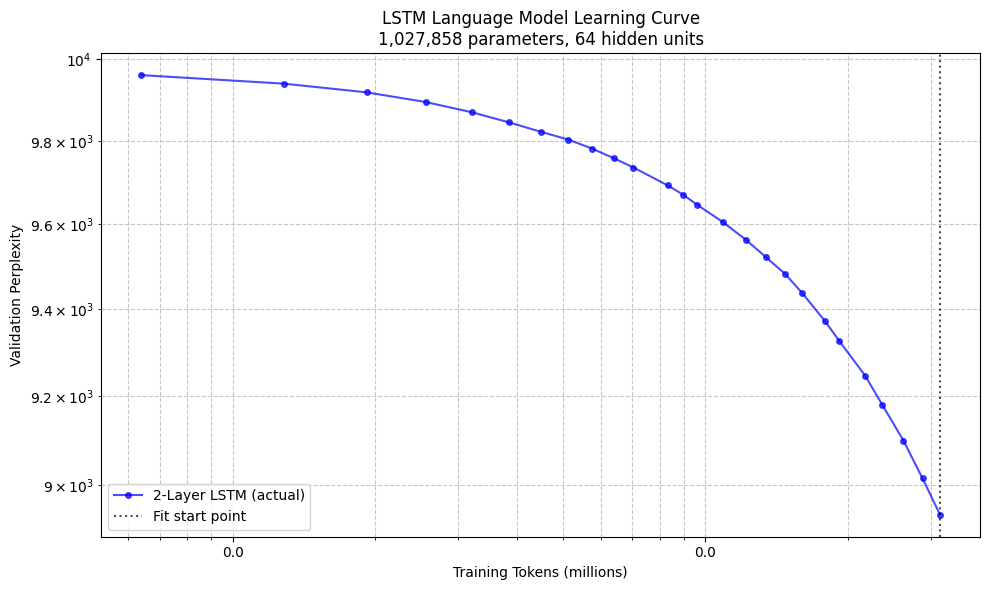

In [14]:
tokens = np.array(loss_times[1:]) * config.batch_size * config.num_steps
perplexities = np.array(metrics_history['val_perplexity'][1:])
fig = create_learning_curve_plot(tokens, perplexities, param_count, config, 1_000_000)

Processing sentences: 0it [00:00, ?it/s]

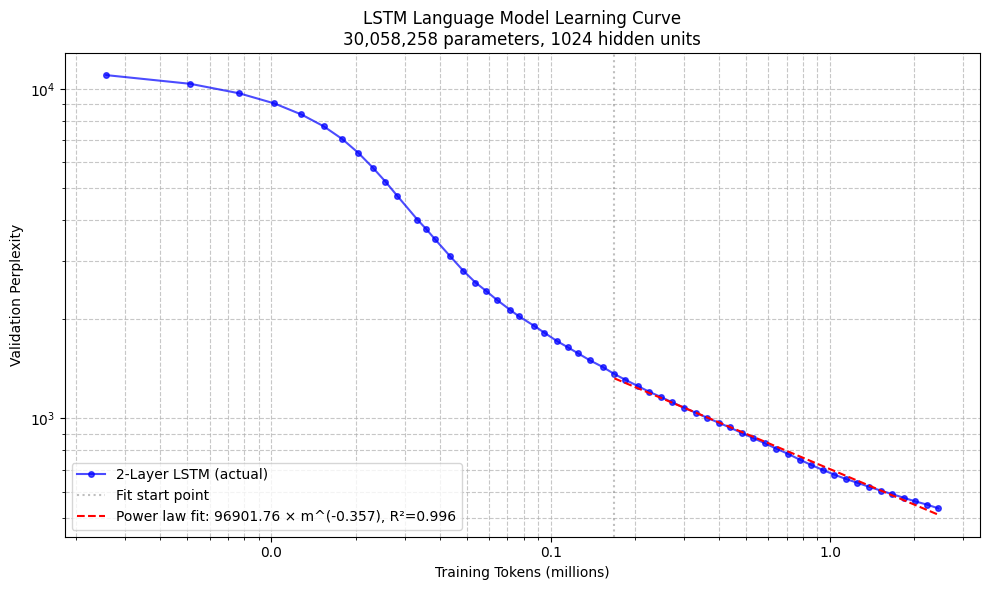

In [ ]:
full_config = Config(
    train_steps=1000,
    max_tokens=1_000_000  # Use None for full dataset, or specify a limit
)
train_lstm_model(full_config)

## Jit-compiled model

(6 min on A100 for 10k steps with bs=32, emb_size=32, hidden_size=64, num_steps=20, num_layers=2)

In [15]:
"""
JAX-optimized LSTM implementation with clear separation of functions and minimal duplication.
"""

import jax
import jax.numpy as jnp
from jax import random as jrandom
import numpy as np
import optax
from flax import nnx
import time
import pickle
import os
import logging
from typing import Dict, Tuple, List, Any, Optional, NamedTuple

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#################################################
# Core data structures
#################################################

class LSTMCarry(NamedTuple):
    """LSTM cell state."""
    h: jnp.ndarray  # hidden state
    c: jnp.ndarray  # cell state

#################################################
# Parameter initialization functions
#################################################

def init_embedding_params(rng, vocab_size, emb_size):
    """Initialize embedding parameters."""
    key = jrandom.fold_in(rng, 0)
    weight = jrandom.normal(key, (vocab_size, emb_size)) * 0.1
    return {"weight": weight}

def init_lstm_cell_params(rng, idx, in_features, hidden_size):
    """Initialize LSTM cell parameters."""
    key = jrandom.fold_in(rng, idx)

    # Input weights (for input, forget, output, and cell gates)
    key, subkey = jrandom.split(key)
    kernel = jrandom.normal(subkey, (in_features, hidden_size * 4)) * 0.1

    # Recurrent weights
    key, subkey = jrandom.split(key)
    recurrent_kernel = jrandom.normal(subkey, (hidden_size, hidden_size * 4)) * 0.1

    # Bias
    bias = jnp.zeros((hidden_size * 4,))

    return {
        "kernel": kernel,
        "recurrent_kernel": recurrent_kernel,
        "bias": bias
    }

def init_output_params(rng, hidden_size, vocab_size):
    """Initialize output layer parameters."""
    key = jrandom.fold_in(rng, 100)  # Use a different part of the key stream
    weight = jrandom.normal(key, (hidden_size, vocab_size)) * 0.1
    bias = jnp.zeros((vocab_size,))
    return {"weight": weight, "bias": bias}

def init_lstm_params(rng, vocab_size, emb_size, hidden_size, num_layers):
    """Initialize all LSTM model parameters."""
    embedding_params = init_embedding_params(rng, vocab_size, emb_size)

    lstm_cell_params = []
    for i in range(num_layers):
        in_features = emb_size if i == 0 else hidden_size
        cell_params = init_lstm_cell_params(rng, i, in_features, hidden_size)
        lstm_cell_params.append(cell_params)

    output_params = init_output_params(rng, hidden_size, vocab_size)

    return {
        "embedding": embedding_params,
        "lstm_cells": lstm_cell_params,
        "output": output_params
    }

#################################################
# Basic forward operations
#################################################

def embedding_forward(params, inputs):
    """Embedding lookup."""
    return jnp.take(params["weight"], inputs, axis=0)

def output_forward(params, x):
    """Output layer forward pass."""
    return jnp.dot(x, params["weight"]) + params["bias"]

#################################################
# JIT-compiled functions for training and evaluation
#################################################

@jax.jit
def forward_train(params, inputs, rng, keep_prob):
    """JIT-compiled forward pass for training with dropout."""
    batch_size, seq_len = inputs.shape
    num_layers = len(params["lstm_cells"])
    hidden_size = params["lstm_cells"][0]["bias"].shape[0] // 4

    # Initialize carries
    carries = []
    for i in range(num_layers):
        h = jnp.zeros((batch_size, hidden_size))
        c = jnp.zeros((batch_size, hidden_size))
        carries = carries + [(h, c)]

    # Embedding lookup
    embedded = embedding_forward(params["embedding"], inputs)

    # Apply dropout to embeddings
    dropout_rng = jrandom.fold_in(rng, 0)
    dropout_mask = jrandom.bernoulli(dropout_rng, keep_prob, embedded.shape) / keep_prob
    embedded = embedded * dropout_mask

    # Process each timestep
    outputs = jnp.zeros((batch_size, seq_len, hidden_size))
    for t in range(seq_len):
        x = embedded[:, t, :]
        h = x
        new_carries = []

        # Process through each LSTM layer
        for i in range(num_layers):
            h_prev, c_prev = carries[i]
            cell_params = params["lstm_cells"][i]

            # LSTM cell computation
            gates = jnp.dot(h, cell_params["kernel"]) + jnp.dot(h_prev, cell_params["recurrent_kernel"]) + cell_params["bias"]
            i_gate, f_gate, g_gate, o_gate = jnp.split(gates, 4, axis=-1)

            i_gate = jax.nn.sigmoid(i_gate)
            f_gate = jax.nn.sigmoid(f_gate)
            g_gate = jnp.tanh(g_gate)
            o_gate = jax.nn.sigmoid(o_gate)

            c = f_gate * c_prev + i_gate * g_gate
            h = o_gate * jnp.tanh(c)

            new_carries.append((h, c))

            # Apply dropout between layers (except after the last layer)
            if i < num_layers - 1:
                layer_dropout_rng = jrandom.fold_in(rng, i + 1)
                dropout_mask = jrandom.bernoulli(layer_dropout_rng, keep_prob, h.shape) / keep_prob
                h = h * dropout_mask

        # Store output for this timestep
        outputs = outputs.at[:, t, :].set(h)
        carries = new_carries

    # Apply output layer
    outputs_flat = outputs.reshape(-1, hidden_size)
    logits_flat = output_forward(params["output"], outputs_flat)
    logits = logits_flat.reshape(batch_size, seq_len, -1)

    return logits

@jax.jit
def forward_eval(params, inputs):
    """JIT-compiled forward pass for evaluation (no dropout)."""
    batch_size, seq_len = inputs.shape
    num_layers = len(params["lstm_cells"])
    hidden_size = params["lstm_cells"][0]["bias"].shape[0] // 4

    # Initialize carries
    carries = []
    for i in range(num_layers):
        h = jnp.zeros((batch_size, hidden_size))
        c = jnp.zeros((batch_size, hidden_size))
        carries = carries + [(h, c)]

    # Embedding lookup
    embedded = embedding_forward(params["embedding"], inputs)

    # Process each timestep
    outputs = jnp.zeros((batch_size, seq_len, hidden_size))
    for t in range(seq_len):
        x = embedded[:, t, :]
        h = x
        new_carries = []

        # Process through each LSTM layer
        for i in range(num_layers):
            h_prev, c_prev = carries[i]
            cell_params = params["lstm_cells"][i]

            # LSTM cell computation
            gates = jnp.dot(h, cell_params["kernel"]) + jnp.dot(h_prev, cell_params["recurrent_kernel"]) + cell_params["bias"]
            i_gate, f_gate, g_gate, o_gate = jnp.split(gates, 4, axis=-1)

            i_gate = jax.nn.sigmoid(i_gate)
            f_gate = jax.nn.sigmoid(f_gate)
            g_gate = jnp.tanh(g_gate)
            o_gate = jax.nn.sigmoid(o_gate)

            c = f_gate * c_prev + i_gate * g_gate
            h = o_gate * jnp.tanh(c)

            new_carries.append((h, c))

        # Store output for this timestep
        outputs = outputs.at[:, t, :].set(h)
        carries = new_carries

    # Apply output layer
    outputs_flat = outputs.reshape(-1, hidden_size)
    logits_flat = output_forward(params["output"], outputs_flat)
    logits = logits_flat.reshape(batch_size, seq_len, -1)

    return logits

@jax.jit
def compute_jitted_loss(logits, targets, weights):
    """JIT-compiled loss computation."""
    batch_size, seq_len = targets.shape
    logits = logits.reshape(-1, logits.shape[-1])
    targets = targets.reshape(-1)

    # Compute cross entropy loss
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)

    # Apply weights if provided
    if weights is not None:
        weights = weights.reshape(-1)
        loss = loss * weights
        # Normalize by sum of weights
        return jnp.sum(loss) / (jnp.sum(weights) + 1e-8)

    return jnp.mean(loss)

@jax.jit
def compute_gradients(params, inputs, targets, weights, rng, keep_prob):
    """JIT-compiled gradient computation."""
    def loss_fn(p):
        logits = forward_train_scan(p, inputs, rng, keep_prob)
        return compute_jitted_loss(logits, targets, weights)

    return jax.grad(loss_fn)(params)

#################################################
# Parameter conversion functions
#################################################

def extract_params_from_nnx(model):
    """Extract parameters from nnx model to functional format."""
    # Get all parameters from the model
    state_dict = nnx.state(model)

    # Organize into the expected format
    params = {
        "embedding": {
            "weight": state_dict["embedding"]["embedding"]
        },
        "lstm_cells": [],
        "output": {
            "weight": state_dict["output"]["kernel"],
            "bias": state_dict["output"]["bias"]
        }
    }

    # Extract LSTM cell parameters
    for i in range(model.num_layers):
        cell_params = {
            "kernel": state_dict[f"lstm_cells_{i}"]["kernel"],
            "recurrent_kernel": state_dict[f"lstm_cells_{i}"]["recurrent_kernel"],
            "bias": state_dict[f"lstm_cells_{i}"]["bias"]
        }
        params["lstm_cells"].append(cell_params)

    return params

def update_nnx_from_params(model, params):
    """Update nnx model from functional parameters."""
    # Create a state dict for the model
    state_dict = nnx.state(model)

    # Update embedding parameters
    state_dict["embedding"]["embedding"] = params["embedding"]["weight"]

    # Update LSTM cell parameters
    for i in range(model.num_layers):
        state_dict[f"lstm_cells_{i}"]["kernel"] = params["lstm_cells"][i]["kernel"]
        state_dict[f"lstm_cells_{i}"]["recurrent_kernel"] = params["lstm_cells"][i]["recurrent_kernel"]
        state_dict[f"lstm_cells_{i}"]["bias"] = params["lstm_cells"][i]["bias"]

    # Update output layer parameters
    state_dict["output"]["kernel"] = params["output"]["weight"]
    state_dict["output"]["bias"] = params["output"]["bias"]

    # Apply the updated state to the model
    nnx.update(model, state_dict)

#################################################
# Training functions
#################################################

def compute_perplexity(loss):
    """Convert loss to perplexity."""
    return jnp.exp(loss)

In [16]:
@jax.jit
def forward_train_scan(params, inputs, rng, keep_prob):
    """JIT-compiled forward pass for training using scan."""
    batch_size, seq_len = inputs.shape
    num_layers = len(params["lstm_cells"])
    hidden_size = params["lstm_cells"][0]["bias"].shape[0] // 4

    # Embedding lookup
    embedded = embedding_forward(params["embedding"], inputs)

    # Apply dropout to embeddings
    dropout_rng = jrandom.fold_in(rng, 0)
    dropout_mask = jrandom.bernoulli(dropout_rng, keep_prob, embedded.shape) / keep_prob
    embedded = embedded * dropout_mask

    # Initialize carries for all layers
    init_carries = []
    for i in range(num_layers):
        h = jnp.zeros((batch_size, hidden_size))
        c = jnp.zeros((batch_size, hidden_size))
        init_carries.append((h, c))

    # Define scan function for processing one time step across all layers
    def lstm_step(layer_carries, x_t):
        h = x_t
        next_carries = []

        # Process through each LSTM layer
        for i in range(num_layers):
            h_prev, c_prev = layer_carries[i]
            cell_params = params["lstm_cells"][i]

            # LSTM cell computation
            gates = jnp.dot(h, cell_params["kernel"]) + \
                   jnp.dot(h_prev, cell_params["recurrent_kernel"]) + \
                   cell_params["bias"]

            # Split gates into components
            i_gate, f_gate, g_gate, o_gate = jnp.split(gates, 4, axis=-1)

            # Apply activations
            i_gate = jax.nn.sigmoid(i_gate)
            f_gate = jax.nn.sigmoid(f_gate)
            g_gate = jnp.tanh(g_gate)
            o_gate = jax.nn.sigmoid(o_gate)

            # Compute new cell and hidden state
            c = f_gate * c_prev + i_gate * g_gate
            h = o_gate * jnp.tanh(c)

            next_carries.append((h, c))

            # Apply dropout between layers (except after the last layer)
            if i < num_layers - 1:
                layer_dropout_rng = jrandom.fold_in(rng, i + 1)
                dropout_mask = jrandom.bernoulli(layer_dropout_rng, keep_prob, h.shape) / keep_prob
                h = h * dropout_mask

        return next_carries, h

    # Use scan to efficiently process the sequence
    final_carries, outputs = jax.lax.scan(
        lstm_step,
        init_carries,
        embedded.transpose(1, 0, 2)  # [seq_len, batch_size, emb_size]
    )

    # Transpose outputs back to [batch_size, seq_len, hidden_size]
    outputs = outputs.transpose(1, 0, 2)

    # Apply output layer
    outputs_flat = outputs.reshape(-1, hidden_size)
    logits_flat = output_forward(params["output"], outputs_flat)
    logits = logits_flat.reshape(batch_size, seq_len, -1)

    return logits

@jax.jit
def forward_eval_scan(params, inputs):
    """JIT-compiled forward pass for evaluation using scan."""
    batch_size, seq_len = inputs.shape
    num_layers = len(params["lstm_cells"])
    hidden_size = params["lstm_cells"][0]["bias"].shape[0] // 4

    # Embedding lookup
    embedded = embedding_forward(params["embedding"], inputs)

    # Initialize carries for all layers
    init_carries = []
    for i in range(num_layers):
        h = jnp.zeros((batch_size, hidden_size))
        c = jnp.zeros((batch_size, hidden_size))
        init_carries.append((h, c))

    # Define scan function for processing one time step across all layers
    def lstm_step(layer_carries, x_t):
        h = x_t
        next_carries = []

        # Process through each LSTM layer
        for i in range(num_layers):
            h_prev, c_prev = layer_carries[i]
            cell_params = params["lstm_cells"][i]

            # LSTM cell computation
            gates = jnp.dot(h, cell_params["kernel"]) + \
                   jnp.dot(h_prev, cell_params["recurrent_kernel"]) + \
                   cell_params["bias"]

            # Split gates into components
            i_gate, f_gate, g_gate, o_gate = jnp.split(gates, 4, axis=-1)

            # Apply activations
            i_gate = jax.nn.sigmoid(i_gate)
            f_gate = jax.nn.sigmoid(f_gate)
            g_gate = jnp.tanh(g_gate)
            o_gate = jax.nn.sigmoid(o_gate)

            # Compute new cell and hidden state
            c = f_gate * c_prev + i_gate * g_gate
            h = o_gate * jnp.tanh(c)

            next_carries.append((h, c))

        return next_carries, h

    # Use scan to efficiently process the sequence
    final_carries, outputs = jax.lax.scan(
        lstm_step,
        init_carries,
        embedded.transpose(1, 0, 2)  # [seq_len, batch_size, emb_size]
    )

    # Transpose outputs back to [batch_size, seq_len, hidden_size]
    outputs = outputs.transpose(1, 0, 2)

    # Apply output layer
    outputs_flat = outputs.reshape(-1, hidden_size)
    logits_flat = output_forward(params["output"], outputs_flat)
    logits = logits_flat.reshape(batch_size, seq_len, -1)

    return logits

In [17]:
def train_lstm_model_jax(config, train_dataset, valid_dataset, original_model=None):
    """Train an LSTM model using JAX-optimized approach."""
    # Initialize RNG
    rng = jrandom.PRNGKey(0)

    # Either extract parameters from existing model or initialize new ones
    if original_model is not None:
        logger.info("Using parameters from existing nnx model")
        params = extract_params_from_nnx(original_model)
    else:
        logger.info("Initializing new model parameters")
        rng, init_rng = jrandom.split(rng)
        params = init_lstm_params(
            init_rng,
            config.vocab_size,
            config.emb_size,
            config.hidden_size,
            config.num_layers
        )

    # Count parameters
    param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
    logger.info(f"Model parameter count: {param_count:,}")

    # Create optimizer
    tx = optax.chain(
        optax.clip_by_global_norm(config.max_grad_norm),
        optax.sgd(learning_rate=config.learning_rate)
    )

    # Initialize optimizer state
    opt_state = tx.init(params)

    # Set up logging steps
    log_steps = jnp.unique(jnp.concatenate([
        jnp.array([0]),
        jnp.int32(1.1**jnp.arange(1, jnp.ceil(jnp.log(config.train_steps)/jnp.log(1.1)))),
        jnp.array([config.train_steps])
    ]))

    # Prepare for training
    metrics_history = {
        'step': [],
        'train_loss': [],
        'train_perplexity': [],
        'train_grad_norm': [],
        'val_loss': [],
        'val_perplexity': []
    }
    loss_times = []

    # Training loop
    logger.info(f"Starting training for {config.train_steps} steps")
    start_time = time.time()
    step = 0

    # Add logging frequency parameter
    log_frequency = min(50, config.train_steps // 20)
    logger.info(f"Using JIT compilation for improved performance")

    for epoch in range(10):  # Limit to 10 epochs max
        train_iterator = train_dataset.iterate_once(config.batch_size, config.num_steps)

        for batch in train_iterator:
            if step >= config.train_steps:
                break

            inputs, targets, weights = batch

            # Generate RNG key for this step
            rng, step_rng = jrandom.split(rng)

            # Forward pass for training (with dropout)
            logits = forward_train_scan(params, inputs, step_rng, config.keep_prob)

            # Compute loss
            loss = compute_jitted_loss(logits, targets, weights)

            # Compute gradients
            grads = compute_gradients(params, inputs, targets, weights, step_rng, config.keep_prob)

            # Compute gradient norm
            grads_flat = jax.tree_util.tree_leaves(grads)
            grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in grads_flat))

            # Update parameters (not JIT-compiled)
            updates, opt_state = tx.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)

            # Log basic progress more frequently
            if step % log_frequency == 0:
                perplexity = compute_perplexity(loss)
                elapsed = time.time() - start_time
                tokens_processed = step * config.batch_size * config.num_steps
                tokens_per_sec = tokens_processed / elapsed if elapsed > 0 else 0

                print(f"Step {step}/{config.train_steps} ({100.0 * step / config.train_steps:.1f}%) | "
                      f"Time: {elapsed:.2f}s | Train Loss: {loss:.4f} | Train PPL: {perplexity:.2f} | "
                      f"Tokens: {tokens_processed:,} ({tokens_per_sec:.1f} tokens/s)")

            # Log detailed metrics at specified intervals
            if step in log_steps:
                perplexity = compute_perplexity(loss)

                # Store step and training metrics
                metrics_history['step'].append(int(step))
                metrics_history['train_loss'].append(float(loss))
                metrics_history['train_perplexity'].append(float(perplexity))
                metrics_history['train_grad_norm'].append(float(grad_norm))
                loss_times.append(int(step))

                # Evaluate on validation set
                valid_losses = []
                valid_weights = []
                valid_iterator = valid_dataset.iterate_once(config.batch_size, config.num_steps)

                for val_batch in valid_iterator:
                    val_inputs, val_targets, val_weights = val_batch

                    # Use forward_eval for evaluation (no dropout)
                    val_logits = forward_eval_scan(params, val_inputs)
                    val_loss = compute_jitted_loss(val_logits, val_targets, val_weights)

                    batch_weight = jnp.sum(val_weights)
                    valid_losses.append(val_loss * batch_weight)
                    valid_weights.append(batch_weight)

                # Compute average validation loss and perplexity
                if sum(valid_weights) > 0:
                    val_loss = sum(valid_losses) / sum(valid_weights)
                    val_perplexity = compute_perplexity(val_loss)
                else:
                    val_loss = jnp.array(0.0)
                    val_perplexity = jnp.array(1.0)

                metrics_history['val_loss'].append(float(val_loss))
                metrics_history['val_perplexity'].append(float(val_perplexity))

                # Print detailed metrics
                elapsed = time.time() - start_time
                logger.info(f"\n=== Detailed Metrics at Step {step}/{config.train_steps} ===")
                logger.info(f"Time elapsed: {elapsed:.2f}s ({elapsed/60:.2f}m)")
                logger.info(f"Training loss: {loss:.4f}, Perplexity: {perplexity:.2f}, Grad Norm: {grad_norm:.2f}")
                logger.info(f"Validation loss: {val_loss:.4f}, Perplexity: {val_perplexity:.2f}")
                logger.info(f"Tokens processed: {step * config.batch_size * config.num_steps:,}")
                logger.info(f"Processing speed: {(step * config.batch_size * config.num_steps) / elapsed:.1f} tokens/sec")
                logger.info("="*50)

            step += 1

            if step >= config.train_steps:
                break

    # Final evaluation
    valid_losses = []
    valid_weights = []
    valid_iterator = valid_dataset.iterate_once(config.batch_size, config.num_steps)

    for val_batch in valid_iterator:
        val_inputs, val_targets, val_weights = val_batch
        val_logits = forward_eval_scan(params, val_inputs)
        val_loss = compute_jitted_loss(val_logits, val_targets, val_weights)

        batch_weight = jnp.sum(val_weights)
        valid_losses.append(val_loss * batch_weight)
        valid_weights.append(batch_weight)

    # Compute average validation loss and perplexity
    if sum(valid_weights) > 0:
        final_loss = sum(valid_losses) / sum(valid_weights)
        final_perplexity = compute_perplexity(final_loss)
    else:
        final_loss = jnp.array(0.0)
        final_perplexity = jnp.array(1.0)

    logger.info("\nTraining completed!")
    logger.info(f"Final validation loss: {final_loss:.4f}, perplexity: {final_perplexity:.2f}")

    # Save metrics history
    metrics_filename = f"{config.results_dir}/{config.optimizer}_jax_metrics_history_steps_{config.train_steps}_layers_{config.num_layers}_hidden_{config.hidden_size}_emb_{config.emb_size}.pkl"
    os.makedirs(config.results_dir, exist_ok=True)
    with open(metrics_filename, 'wb') as f:
        pickle.dump((config, loss_times, metrics_history, param_count), f)

    # Add this adjustment to make sure arrays match for plotting
    if len(loss_times) != len(metrics_history['val_perplexity']):
        # Ensure arrays are the same length
        min_len = min(len(loss_times), len(metrics_history['val_perplexity']))
        loss_times = loss_times[:min_len]
        for key in metrics_history:
            metrics_history[key] = metrics_history[key][:min_len]

    return log_steps, metrics_history, param_count, params

In [18]:
class BatchedDatasetAdapter:
    """A more memory-efficient dataset adapter that processes data in batches."""

    def __init__(self, vocab, split='train', deterministic=False, max_tokens=None,
                 cache_dir='./data_cache', batch_size=128, num_steps=20,
                 prefetch_batches=10):
        self._vocab = vocab
        self._deterministic = deterministic
        self._max_tokens = max_tokens
        self._cache_dir = cache_dir
        self._batch_size = batch_size
        self._num_steps = num_steps
        self._prefetch_batches = prefetch_batches
        self._total_tokens = 0

        # Create cache directory if it doesn't exist
        os.makedirs(self._cache_dir, exist_ok=True)

        # Generate a unique cache key based on parameters
        vocab_size = vocab.num_tokens
        self._cache_key = f"{split}_vocab{vocab_size}_maxtokens{max_tokens}"
        self._meta_cache_path = os.path.join(self._cache_dir, f"{self._cache_key}_meta.pkl")

        # Load or create dataset metadata
        if os.path.exists(self._meta_cache_path):
            logger.info(f"Loading cached dataset metadata from {self._meta_cache_path}")
            with open(self._meta_cache_path, 'rb') as f:
                self._metadata = pickle.load(f)
                self._total_tokens = self._metadata['total_tokens']
                self._num_batches = self._metadata['num_batches']
                self._batch_indices = self._metadata['batch_indices']
            logger.info(f"Metadata indicates {self._total_tokens} tokens in {self._num_batches} batches")
        else:
            # Initialize the dataset and process in batches for caching
            logger.info(f"No cache found. Loading {split} dataset and preparing batch indices...")
            self._dataset = load_dataset("lm1b", split=split, streaming=True)
            self._prepare_batch_indices()

            # Save metadata to cache
            with open(self._meta_cache_path, 'wb') as f:
                self._metadata = {
                    'total_tokens': self._total_tokens,
                    'num_batches': self._num_batches,
                    'batch_indices': self._batch_indices
                }
                pickle.dump(self._metadata, f)

    def _prepare_batch_indices(self):
        """Process the dataset once to create batch indices and cache information."""
        # Process sentences and collect indices for efficient batch creation
        all_sentence_indices = []
        sentence_idx = 0
        token_count = 0

        # Process example stream
        for example in tqdm(self._dataset, desc="Indexing dataset"):
            text = example["text"]
            if not text.strip():
                continue

            # Just get sentence length without storing the full tokenized content
            sentence_length = len(text.strip().split()) + 2  # +2 for start/end tokens

            # Store index and length
            all_sentence_indices.append((sentence_idx, sentence_length))
            token_count += sentence_length
            sentence_idx += 1

            # Check if we've reached max tokens limit
            if self._max_tokens is not None and token_count >= self._max_tokens:
                break

        self._total_tokens = token_count
        logger.info(f"Indexed {len(all_sentence_indices)} sentences with {token_count} tokens")

        # Create cache indices for efficient batch loading
        # We're storing which sentences go into which batch file
        self._batch_indices = []
        current_batch = []
        current_batch_size = 0

        # Shuffle if not deterministic
        if not self._deterministic:
            random.shuffle(all_sentence_indices)

        # Group sentences into batch files
        target_batch_size = self._batch_size * self._num_steps * 100  # Each file has ~100 batches

        for sent_idx, sent_length in all_sentence_indices:
            current_batch.append((sent_idx, sent_length))
            current_batch_size += sent_length

            if current_batch_size >= target_batch_size and len(current_batch) > 0:
                self._batch_indices.append(current_batch)
                current_batch = []
                current_batch_size = 0

        # Add the last batch if it has data
        if len(current_batch) > 0:
            self._batch_indices.append(current_batch)

        self._num_batches = len(self._batch_indices)
        logger.info(f"Created {self._num_batches} batch files for efficient loading")

    def _get_batch_filename(self, batch_idx):
        """Get the filename for a specific batch cache."""
        return os.path.join(self._cache_dir, f"{self._cache_key}_batch{batch_idx}.pkl")

    def _parse_sentence(self, text):
        """Convert a text sentence into token IDs."""
        s_id = self._vocab.s_id
        return [s_id] + [self._vocab.get_id(word) for word in text.strip().split()] + [s_id]

    def _prepare_batch(self, batch_idx):
        """Prepare and cache a specific batch if not already cached."""
        batch_filename = self._get_batch_filename(batch_idx)

        # Check if batch is already cached
        if os.path.exists(batch_filename):
            logger.debug(f"Loading cached batch {batch_idx} from {batch_filename}")
            with open(batch_filename, 'rb') as f:
                return pickle.load(f)

        # Need to process this batch
        logger.debug(f"Processing batch {batch_idx} and caching to {batch_filename}")

        # Get the sentence indices for this batch
        sentence_indices = self._batch_indices[batch_idx]

        # Load those specific sentences
        # This requires restarting the dataset iterator
        sentences = []
        dataset_iter = iter(self._dataset)

        # Skip to the sentences we need
        current_example = 0
        for sent_idx, _ in sentence_indices:
            while current_example <= sent_idx:
                try:
                    example = next(dataset_iter)
                    if example["text"].strip():
                        if current_example == sent_idx:
                            sentences.append(self._parse_sentence(example["text"]))
                        current_example += 1
                except StopIteration:
                    break

        # Cache the processed batch
        with open(batch_filename, 'wb') as f:
            pickle.dump(sentences, f)

        return sentences

    def iterate_once(self, batch_size, num_steps):
        """Generate batches efficiently with prefetching."""
        assert batch_size == self._batch_size, f"Batch size mismatch: requested {batch_size}, dataset uses {self._batch_size}"
        assert num_steps == self._num_steps, f"Steps mismatch: requested {num_steps}, dataset uses {self._num_steps}"

        # Determine which batch files to use (all of them for a single epoch)
        batch_file_indices = list(range(self._num_batches))

        # Shuffle batch files if not deterministic
        if not self._deterministic:
            random.shuffle(batch_file_indices)

        # Create prefetch queue for background processing
        # Use a simple approach that doesn't require additional threads
        prefetch_queue = []

        # Helper function to generate batches from a list of sentences
        def generate_batches_from_sentences(sentences):
            # Similar to the original DatasetAdapter implementation
            np.random.shuffle(sentences) if not self._deterministic else None

            streams = [None] * batch_size
            sentence_idx = 0

            while sentence_idx < len(sentences):
                x = np.zeros([batch_size, num_steps], np.int32)
                y = np.zeros([batch_size, num_steps], np.int32)
                w = np.zeros([batch_size, num_steps], np.uint8)

                for i in range(batch_size):
                    tokens_filled = 0
                    while tokens_filled < num_steps:
                        if streams[i] is None or len(streams[i]) <= 1:
                            if sentence_idx >= len(sentences):
                                break
                            streams[i] = sentences[sentence_idx]
                            sentence_idx += 1

                        num_tokens = min(len(streams[i]) - 1, num_steps - tokens_filled)
                        x[i, tokens_filled:tokens_filled+num_tokens] = streams[i][:num_tokens]
                        y[i, tokens_filled:tokens_filled+num_tokens] = streams[i][1:num_tokens+1]
                        w[i, tokens_filled:tokens_filled+num_tokens] = 1
                        streams[i] = streams[i][num_tokens:]
                        tokens_filled += num_tokens

                if np.any(w):  # Only yield if there's actual data
                    yield jnp.array(x), jnp.array(y), jnp.array(w)

        # Initial prefetch
        for i in range(min(self._prefetch_batches, len(batch_file_indices))):
            batch_idx = batch_file_indices[i]
            sentences = self._prepare_batch(batch_idx)
            prefetch_queue.append((batch_idx, sentences))

        # Process all batch files
        for i in range(len(batch_file_indices)):
            # Get the current batch
            if i < len(prefetch_queue):
                _, sentences = prefetch_queue[i]
            else:
                batch_idx = batch_file_indices[i]
                sentences = self._prepare_batch(batch_idx)

            # Prefetch next batch if available
            if i + self._prefetch_batches < len(batch_file_indices):
                next_idx = batch_file_indices[i + self._prefetch_batches]
                # This would ideally happen in a background thread
                # but we'll do it synchronously for simplicity
                next_sentences = self._prepare_batch(next_idx)
                prefetch_queue.append((next_idx, next_sentences))

            # Generate batches from current sentences
            yield from generate_batches_from_sentences(sentences)

In [19]:
test_config = Config(
    batch_size=32,
    num_steps=20,
    train_steps=100,
    vocab_size=10000,
    emb_size=32,
    hidden_size=64,
    num_layers=2,
    max_tokens=1_000_000,
    max_val_tokens=10_000,
    results_dir="results/jax_test"
)

In [26]:
def train_with_test_config_jax():
    """Run training with a small configuration for testing."""
    # Get vocabulary file
    vocab_file = get_vocab_file()

    # Create a small test configuration
    config = Config(
        batch_size=32,
        num_steps=20,
        train_steps=1000,
        vocab_size=10000,
        emb_size=32,
        hidden_size=64,
        num_layers=2,
        max_tokens=30_000_000,
        max_val_tokens=10_000,
        results_dir="results/jax_test"
    )

    # Load vocabulary
    logger.info(f"Loading vocabulary from {vocab_file}")
    vocab = Vocabulary.from_file(vocab_file, max_vocab_size=test_config.vocab_size)
    logger.info(f"Vocabulary size: {vocab.num_tokens}")

    # # Create datasets
    logger.info("Creating training dataset...")
    train_dataset = DatasetAdapter(vocab, split='train', max_tokens=test_config.max_tokens)

    logger.info("Creating validation dataset...")
    valid_dataset = DatasetAdapter(vocab, split='test', deterministic=True, max_tokens=test_config.max_val_tokens)

    # Train model
    logger.info("Starting JAX-optimized training with test configuration...")
    log_steps, metrics_history, param_count, final_params = train_lstm_model_jax(
        config, train_dataset, valid_dataset
    )

    return log_steps, metrics_history, param_count, final_params

In [27]:
log_steps, metrics_history, param_count, final_params = train_with_test_config_jax()

Step 0/1000 (0.0%) | Time: 0.03s | Train Loss: 9.2103 | Train PPL: 9999.94 | Tokens: 0 (0.0 tokens/s)
Step 50/1000 (5.0%) | Time: 2.30s | Train Loss: 9.1056 | Train PPL: 9005.34 | Tokens: 32,000 (13934.0 tokens/s)
Step 100/1000 (10.0%) | Time: 3.94s | Train Loss: 8.9467 | Train PPL: 7682.47 | Tokens: 64,000 (16239.7 tokens/s)
Step 150/1000 (15.0%) | Time: 5.48s | Train Loss: 8.7578 | Train PPL: 6359.89 | Tokens: 96,000 (17521.0 tokens/s)
Step 200/1000 (20.0%) | Time: 7.00s | Train Loss: 8.2289 | Train PPL: 3747.78 | Tokens: 128,000 (18280.3 tokens/s)
Step 250/1000 (25.0%) | Time: 8.46s | Train Loss: 7.9020 | Train PPL: 2702.79 | Tokens: 160,000 (18919.7 tokens/s)
Step 300/1000 (30.0%) | Time: 10.09s | Train Loss: 7.5064 | Train PPL: 1819.60 | Tokens: 192,000 (19030.9 tokens/s)
Step 350/1000 (35.0%) | Time: 11.47s | Train Loss: 7.2405 | Train PPL: 1394.80 | Tokens: 224,000 (19535.0 tokens/s)
Step 400/1000 (40.0%) | Time: 12.89s | Train Loss: 7.1243 | Train PPL: 1241.81 | Tokens: 256,000

In [ ]:
vocab_file = get_vocab_file()

config = Config(
    batch_size=32,
    num_steps=20,
    train_steps=10000,
    vocab_size=10000,
    emb_size=32,
    hidden_size=64,
    num_layers=2,
    max_tokens=30_000_000,
    max_val_tokens=10_000,
    results_dir="results/jax_test"
)

# Load vocabulary
logger.info(f"Loading vocabulary from {vocab_file}")
vocab = Vocabulary.from_file(vocab_file, max_vocab_size=config.vocab_size)
logger.info(f"Vocabulary size: {vocab.num_tokens}")

# # Create datasets
logger.info("Creating training dataset...")
train_dataset = DatasetAdapter(vocab, split='train', max_tokens=test_config.max_tokens)

logger.info("Creating validation dataset...")
valid_dataset = DatasetAdapter(vocab, split='test', deterministic=True, max_tokens=test_config.max_val_tokens)

Processing dataset: 0it [00:00, ?it/s]

Processing dataset: 0it [00:00, ?it/s]

In [ ]:
# Train model
logger.info("Starting JAX-optimized training with test configuration...")
log_steps, metrics_history, param_count, final_params = train_lstm_model_jax(
    config, train_dataset, valid_dataset
)

Step 0/10000 (0.0%) | Time: 0.02s | Train Loss: 9.2105 | Train PPL: 10001.27 | Tokens: 0 (0.0 tokens/s)
Step 50/10000 (0.5%) | Time: 2.36s | Train Loss: 9.1115 | Train PPL: 9058.58 | Tokens: 32,000 (13569.7 tokens/s)
Step 100/10000 (1.0%) | Time: 4.18s | Train Loss: 8.9521 | Train PPL: 7723.81 | Tokens: 64,000 (15316.0 tokens/s)
Step 150/10000 (1.5%) | Time: 5.93s | Train Loss: 8.7600 | Train PPL: 6373.97 | Tokens: 96,000 (16192.8 tokens/s)
Step 200/10000 (2.0%) | Time: 7.56s | Train Loss: 8.4238 | Train PPL: 4554.21 | Tokens: 128,000 (16942.0 tokens/s)
Step 250/10000 (2.5%) | Time: 9.46s | Train Loss: 7.7091 | Train PPL: 2228.62 | Tokens: 160,000 (16910.4 tokens/s)
Step 300/10000 (3.0%) | Time: 11.19s | Train Loss: 7.5055 | Train PPL: 1817.94 | Tokens: 192,000 (17163.6 tokens/s)
Step 350/10000 (3.5%) | Time: 13.23s | Train Loss: 7.4139 | Train PPL: 1658.95 | Tokens: 224,000 (16935.7 tokens/s)
Step 400/10000 (4.0%) | Time: 15.00s | Train Loss: 6.9530 | Train PPL: 1046.32 | Tokens: 256,

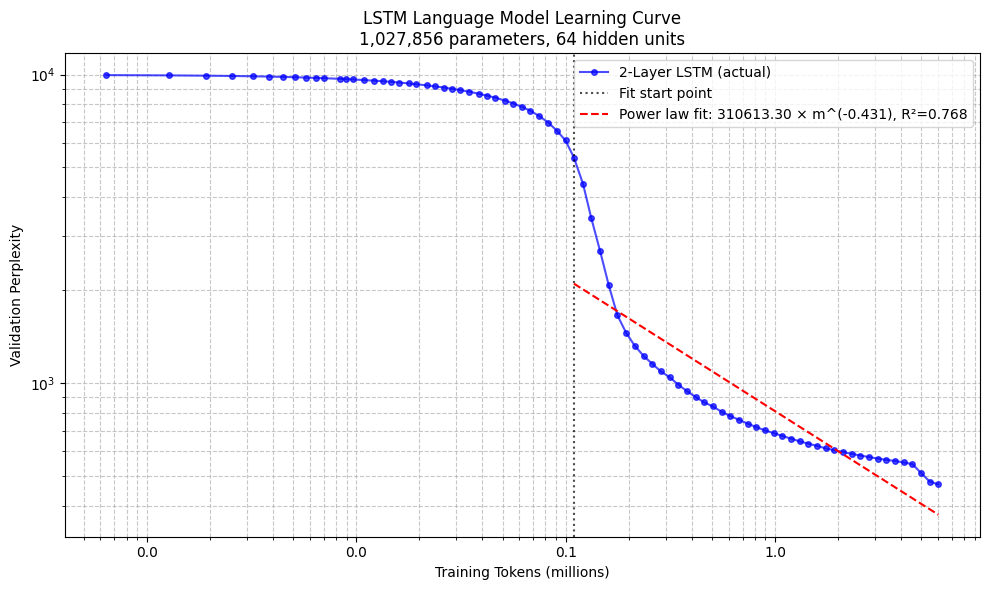

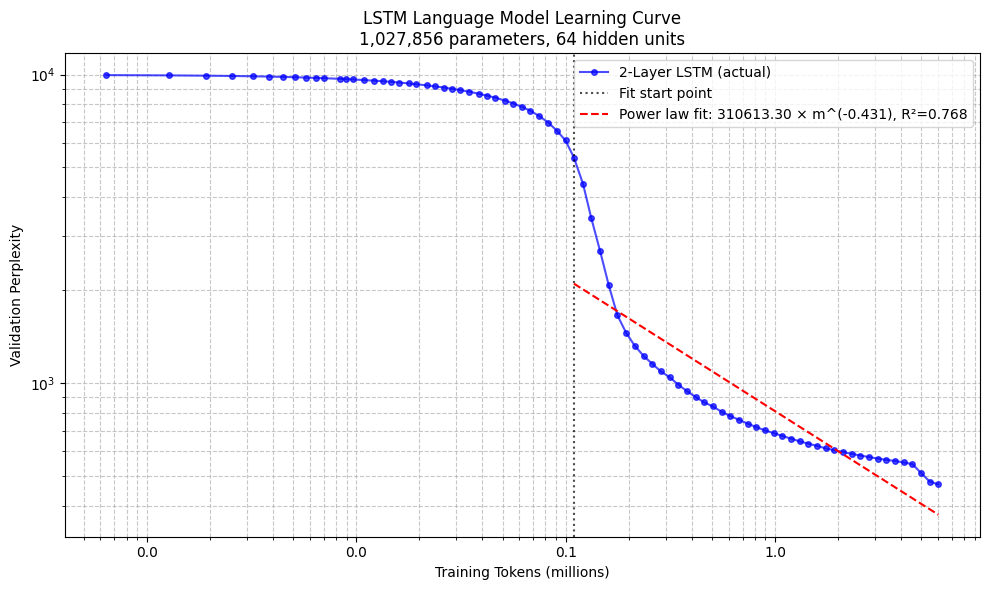

In [ ]:
# Make sure we have matching array lengths for plotting
tokens = np.array(log_steps[1:]) * test_config.batch_size * test_config.num_steps
perplexities = np.array(metrics_history['val_perplexity'][1:])

# Ensure same length
min_len = min(len(tokens), len(perplexities))
tokens = tokens[:min_len]
perplexities = perplexities[:min_len]

# Create learning curve plot
create_learning_curve_plot(tokens, perplexities, param_count, test_config, fit_start_tokens=1_100_00)